In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from scipy.interpolate import splrep, splev

import gpxpy
import gpxpy.gpx

from tcxreader.tcxreader import TCXReader, TCXTrackPoint

In [2]:
strava_dir = Path('../data/strava/')
garmin_dir = Path('../data/garmin/')
runalyze_dir = Path('../data/runalyze/')

strava_files = list(strava_dir.glob('*.gpx'))
garmin_files = list(garmin_dir.glob('*.tcx'))
runalyze_files = list(runalyze_dir.glob('*.gpx'))

print('Strava:')
print(strava_files)
print('Garmin:')
print(garmin_files)
print('runalyze:')
print(runalyze_files)

Strava:
[PosixPath('../data/strava/activity_test_fixed.gpx'), PosixPath('../data/strava/Happy_Diwali__fix.gpx'), PosixPath('../data/strava/Lauf_am_Abend_fix.gpx'), PosixPath('../data/strava/Die_Luft_ist_rein.gpx'), PosixPath('../data/strava/Happy_Diwali_.gpx'), PosixPath('../data/strava/Lauf_am_Abend.gpx')]
Garmin:
[PosixPath('../data/garmin/activity_12675496001.tcx'), PosixPath('../data/garmin/activity_test.tcx'), PosixPath('../data/garmin/activity_12780290363.tcx'), PosixPath('../data/garmin/activity_12702654569.tcx')]
runalyze:
[PosixPath('../data/runalyze/62480-Activity_2023-11-18_19-45_81257088.gpx')]


In [3]:
gpx_filename = strava_files[2]
gpx_file = gpx_filename.open()

gpx = gpxpy.parse(gpx_file)

In [4]:
gpx.tracks[0].type

'running'

In [94]:
tcx_filename = garmin_files[0]
tcx_reader = TCXReader()

tcx = tcx_reader.read(tcx_filename, only_gps=False)

In [95]:
gpx_longitudes = np.array([point.longitude for point in gpx.tracks[0].segments[0].points])
gpx_latitudes  = np.array([point.latitude for point in gpx.tracks[0].segments[0].points])
gpx_times      = np.array([point.time.replace(tzinfo=None) for point in gpx.tracks[0].segments[0].points], dtype='datetime64')

In [96]:
tcx_longitudes = np.array([point.longitude for point in tcx.trackpoints])
tcx_latitudes  = np.array([point.latitude for point in tcx.trackpoints])
tcx_times      = np.array([point.time for point in tcx.trackpoints], dtype='datetime64')
tcx_hrs        = np.array([point.hr_value for point in tcx.trackpoints])
tcx_cadences   = np.array([point.tpx_ext['RunCadence'] for point in tcx.trackpoints])

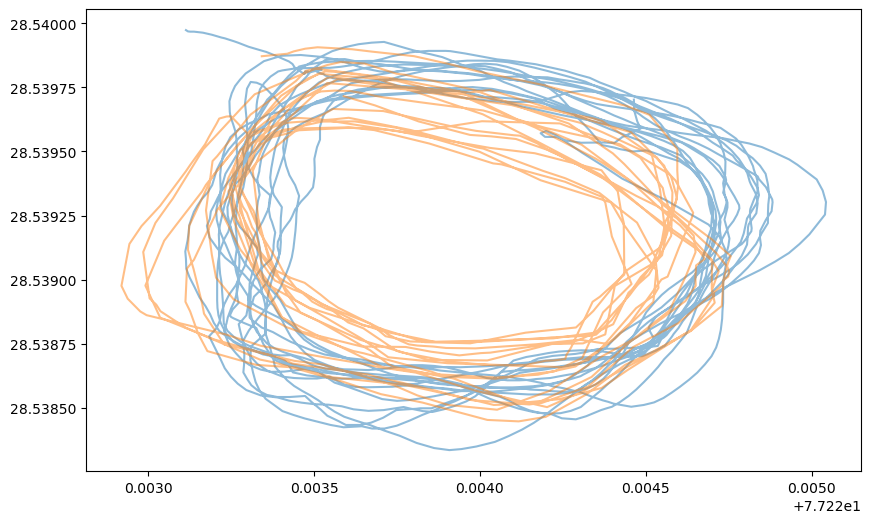

In [97]:
fig = plt.figure(figsize=(10,6))

plt.plot(gpx_longitudes, gpx_latitudes, alpha=0.5)
plt.plot(tcx_longitudes, tcx_latitudes, alpha=0.5)

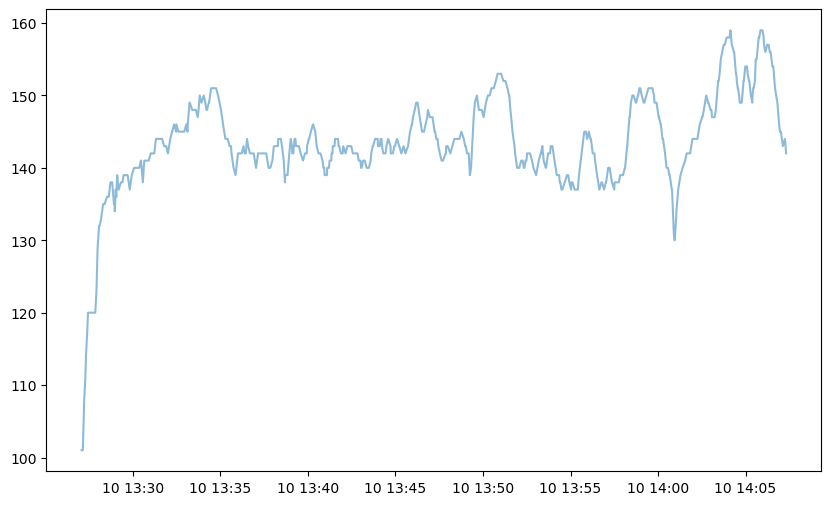

In [98]:
fig = plt.figure(figsize=(10,6))

plt.plot(tcx_times, tcx_hrs, alpha=0.5)

In [99]:
# Interpolate tcx heartrates and cadences to gpx timestamps
tck_hr = splrep(tcx_times.astype('d'), tcx_hrs, s=1)
gpx_hrs = splev(gpx_times.astype('d'), tck_hr, der=0)

tck_cad = splrep(tcx_times.astype('d'), tcx_cadences, s=1)
gpx_cadences = splev(gpx_times.astype('d'), tck_cad, der=0)

/home/paul/anaconda3/envs/gpsfix/lib/python3.9/site-packages/scipy/interpolate/_fitpack_impl.py:285: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))


(0.0, 200.0)

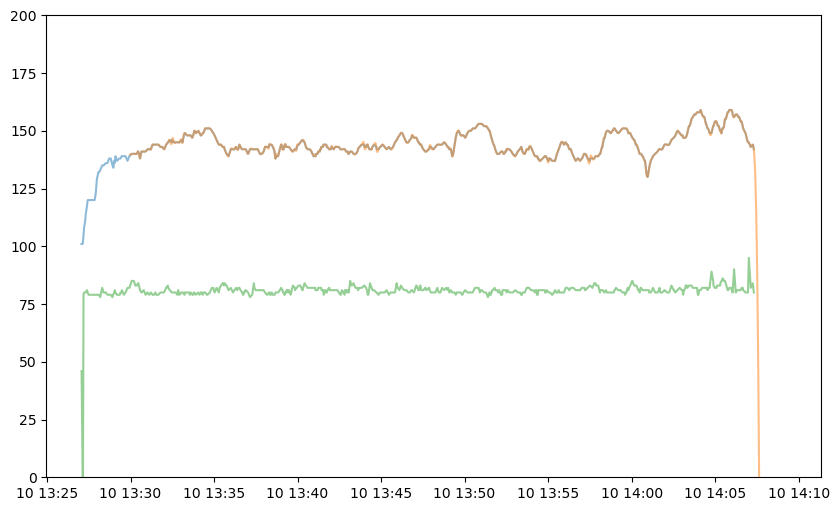

In [102]:
fig = plt.figure(figsize=(10,6))

plt.plot(tcx_times, tcx_hrs, alpha=0.5)
plt.plot(gpx_times, gpx_hrs, alpha=0.5)

plt.plot(tcx_times, tcx_cadences, alpha=0.5)
plt.plot(gpx_times, gpx_cadences, alpha=0.5)
plt.ylim(0, 200)

In [89]:
# And add the heartrate and cadence data to the gpx file as extension

# Import required packages here
try:
    # Load LXML or fallback to cET or ET 
    import lxml.etree as mod_etree  # type: ignore
except:
    try:
        import xml.etree.cElementTree as mod_etree # type: ignore
    except:
        import xml.etree.ElementTree as mod_etree # type: ignore

In [90]:
#definition of extension
namespace = '{gpxtpx}'
#add extension to header
nsmap = {namespace[1:-1]:'http://www.garmin.com/xmlschemas/TrackPointExtension/v1'}
gpx.nsmap =nsmap

for i, point in enumerate(gpx.tracks[0].segments[0].points):
    #create extension element
    root = mod_etree.Element(f'{namespace}TrackPointExtension')
    root_hr  = mod_etree.SubElement(root, f'{namespace}hr')
    root_cad = mod_etree.SubElement(root, f'{namespace}cad')
    root_hr.text  = str(int(gpx_hrs[i]))
    root_cad.text = str(int(gpx_cadences[i]))
    
    point.extensions.append(root)

In [51]:
print(gpx.to_xml())

<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd" version="1.1" creator="StravaGPX Android">
  <metadata>
    <time>2023-11-18T14:15:09Z</time>
  </metadata>
  <trk>
    <name>Lauf am Abend</name>
    <type>running</type>
    <trkseg>
      <trkpt lat="28.539842" lon="77.2234">
        <ele>224.6</ele>
        <time>2023-11-18T14:15:09Z</time>
        <extensions>
          <gpxtpx:TrackPointExtension>
            <gpxtpx:hr>83</gpxtpx:hr>
            <gpxtpx:cad>122</gpxtpx:cad>
          </gpxtpx:TrackPointExtension>
        </extensions>
      </trkpt>
      <trkpt lat="28.539838" lon="77.223419">
        <ele>224.6</ele>
        <time>2023-11-18T14:15:10Z</time>
        <extensions>
          <gpxtpx:TrackPointExtension>
       

In [91]:
output_file = gpx_filename.with_name(gpx_filename.stem + '_fix' + gpx_filename.suffix)

with open(output_file, 'w') as f:
    f.write(gpx.to_xml())